<a href="https://colab.research.google.com/github/hyesukim1/chest_X_ray_images_binary_classification/blob/main/Chest_X_ray__images_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle API로 연결하여 데이터 로드

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
# ls -1ha kaggle.json

# json file 이동시키기
!mkdir -p ~/.kaggle1
!cp kaggle.json ~/.kaggle/

# permission warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
!ls

In [ ]:
# zip 파일 풀기
!unzip -qq "/content/chest-xray-pneumonia.zip"

---

# 프로젝트 설명

In [ ]:
# 데이터 경로
data_path = '/content/chest_xray/'

# 훈련, 검증, 테스트 데이터 경로 설정
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

In [ ]:
from glob import glob # 파일들의 리스트를 뽑을 때 사용

print(f'num of train data: {len(glob(train_path + "*/*"))}')
print(f'num of val data: {len(glob(valid_path + "*/*"))}')
print(f'num of test data: {len(glob(test_path + "*/*"))}')

In [ ]:
all_normal_imgs = []
all_pneumonia_imgs = []

for categories in ['train/', 'val/', 'test/']:
  data_category_path = data_path + categories
  normal_imgs = glob(data_category_path + 'NORMAL/*')
  pneumonia_imgs = glob(data_category_path + 'PNEUMONIA/*')

  all_normal_imgs.extend(normal_imgs)
  all_pneumonia_imgs.extend(pneumonia_imgs)

print(f'정상 흉부 이미지 개수 : {len(all_normal_imgs)}')
print(f'폐렴 흉부 이미지 개수 : {len(all_pneumonia_imgs)}')

# 데이터 시각화

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7,7))

label = ['Normal', 'Pneumonia']

plt.pie([len(all_normal_imgs), len(all_pneumonia_imgs)],
        labels = label,
        autopct = '%.f%%')

In [ ]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_paths, rows=2, cols=3):
  assert len(img_paths) <= rows*cols

  mpl.rc('font', size=8)
  plt.figure(figsize=(15, 8))
  grid = gridspec.GridSpec(rows, cols)

  for idx, img_path in enumerate(img_paths):
    image = cv2.imread(img_path)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

In [ ]:
# 정상 폐 x-ray 이미지 화
num_of_imgs = 6
normal_img_paths = all_normal_imgs[-num_of_imgs:]

show_image(normal_img_paths)

In [ ]:
# 폐렴 x-ray 시각화, 뿌연 부분이 많음
pneumonia_img_paths = all_pneumonia_imgs[-num_of_imgs:]
show_image(pneumonia_img_paths)

# 베이스라인 모델

In [ ]:
import torch
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 데이터 경로
data_path = '/content/chest_xray/'

# 훈련, 검증, 테스트 데이터 경로 설정
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

In [ ]:
from torchvision import transforms

# 훈련 데이터 이미지 변환
transform_train = transforms.Compose([
                                      transforms.Resize((250, 250)), # 이미지 크기 조정
                                      transforms.CenterCrop(180), # 중앙 이미지 확대
                                      transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                                      transforms.RandomVerticalFlip(0.2), # 상하대칭
                                      transforms.RandomRotation(20), # 이미지 회전
                                      transforms.ToTensor(), # 텐서 객체로 변환
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 테스트 데이터 이미지 변환
transform_test = transforms.Compose([
                                    transforms.Resize((250, 250)),
                                    transforms.CenterCrop(180),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))
])

In [ ]:
from torchvision.datasets import ImageFolder

# 훈련 데이터셋
datasets_train = ImageFolder(root=train_path, transform=transform_train)
datasets_valid = ImageFolder(root=valid_path, transform=transform_test)

In [ ]:
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# 제너레이터 시드값 고정
g = torch.Generator()
g.manual_seed(0)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

## EfficientNet
### rethinking model scaling for convolutional neural networks

#### 모델을 크게 만드는 법
1. depth를 깊게 만드는 것
2. channel width(filter 개수)를 늘리는 것
- width가 넓을 수록 미세한 정보가 많이 담아짐
3. input image의 해상도를 올리는 것

### 모델 키운 단계
- STEP 1: ϕ = 1로 고정하고, α,β,γ에 대해서 작게 grid search를 수행한다. 찾은 값은 α=1.2, β=1.1,γ=1.15로 α⋅β2⋅γ2≈2이다.
- STEP 2: 이제 α,β,γ를 고정하고 ϕ를 변화시키면서 전체적인 크기를 키운다


EfficientNet -B0 Network
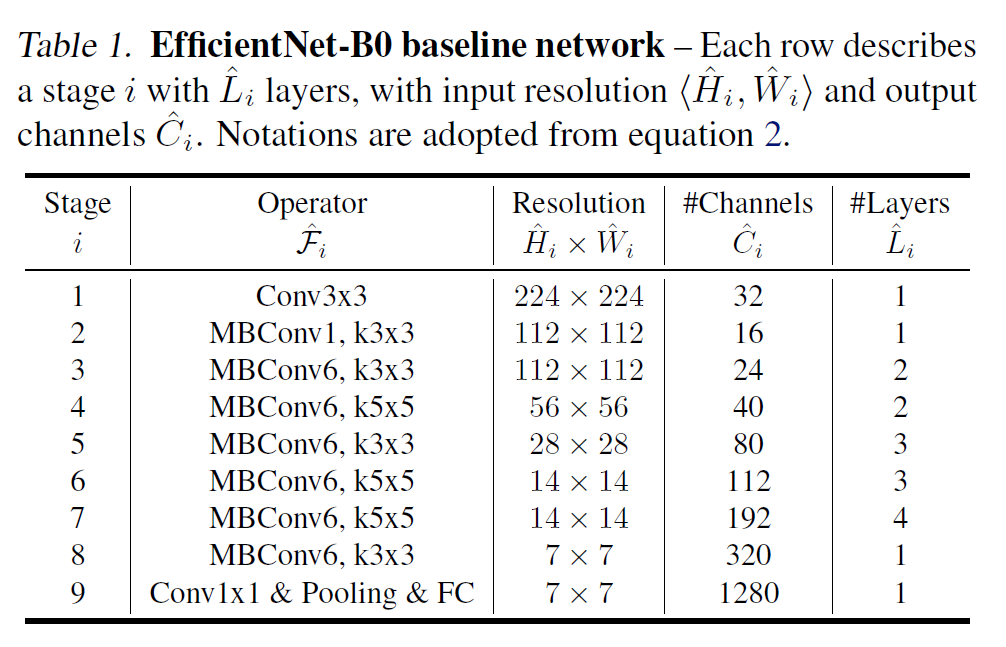

In [ ]:
!pip install efficientnet-pytorch==0.7.1

In [ ]:
# 모델 생성
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
model = model.to(device)

In [ ]:
print('모델 파라미터 수 : ', sum(param.numel() for param in model.parameters()))

In [ ]:
import torch.nn as nn

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score # 재현율 계산 함수
from sklearn.metrics import f1_score # f1 점수 계산 함수
from tqdm.notebook import tqdm

# train function

def train(model, loader_train, loader_valid, criterion, optimizer, scheduler=None, epochs=10, save_file='model_state'):
  valid_loss_min = np.inf # 최소 손실값 초기화

  for epoch in range(epochs):
    print(f'에폭 [{epoch+1}/{epochs}] \n------------------------')

    #############훈련
    model.train() # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에포크별 손실값 초기화(훈련 데이터용)
    # 미니배치 단위로 '반복 횟수'만큼 반복
    for images, labels in tqdm(loader_train):
      # 이미지. 레이블 데이터 미니배치를 장비에 할당
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # 옵티마이저 내 기울기 초기화
      outputs = model(images) # 순전파
      loss = criterion(outputs, labels) # 손실값 계산
      epoch_train_loss += loss.item()
      loss.backward() # 역전파
      optimizer.step() # 가중치 갱신
      if scheduler != None: # 스케줄러 학습 갱신
        scheduler.step()
      print(f'\t훈련 데이터 손실값: {epoch_train_loss/len(loader_train):.4f}')
    
    #############검증
    model.eval() # 모델을 평가 상태로 설정
    epoch_valid_loss = 0 # 에포크별 손실값 초기화(검증 데이터 용)
    preds_list = [] # 예측값 저장
    true_list = [] # 실제값 저장

    with torch.no_grad(): # 기울기 계산 비활성화
      # 하나의 에포크 만큼의 데이터를 미니배치 단위로 검증
      for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images) # 순전파
        loss = criterion(outputs, labels) # 손실값 계산
        epoch_valid_loss += loss.item() # 현재 배치에서 손실 추가

        # 예측값 및 실제값
        preds = torch.max(outputs.cpu(), dim=1)[1].numpy()
        true = labels.cpu().numpy()

        preds_list.extend(preds)
        true_list.extend(true)
    
    # 현재 에포크의 검증 완료
    print(f'\t 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
    
    # 평가지표 계산
    val_accuracy = accuracy_score(true_list, preds_list)
    val_recall = recall_score(true_list, preds_list)
    val_f1_score = f1_score(true_list, preds_list)
    print(f't\ 정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수: {val_f1_score:.4f}')

    # 현 에포크에서 손실값이 최소 손실값 이하면 모델 가중치 저장
    if epoch_valid_loss <= valid_loss_min:
      print(f'\t### 검증 데이터 손실값 삼소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}. 모델 저장')
      # 모델 가중치를 파일로 저장
      torch.save(model.state_dict(), save_file)
      valid_loss_min = epoch_valid_loss # 최소 손실값 갱신
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환


In [ ]:
# 모델 훈련
model_state_dict = train(model=model, 
                         loader_train = loader_train,
                         loader_valid = loader_valid,
                         criterion = criterion,
                         optimizer = optimizer)

In [ ]:
# 최적의 가중치 가져오기
model.load_state_dict(model_state_dict)

In [ ]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)
loader_test = DataLoader(dataset= datasets_test, batch_size=batch_size,
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

In [ ]:
def predict(model, loader_test, return_true=False):
  model.eval()
  preds_list = []
  true_list = []

  with torch.no_grad():
    for images, labels in loader_test:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.max(outputs.cpu(), dim=1)[1].numpy()
      true = labels.cpu().numpy()

      preds_list.extend(preds)
      true_list.extend(true)

  if return_true:
    return true_list, preds_list
  else:
    return preds_list

In [ ]:
true_list, preds_list = predict(model=model,
                                loader_test = loader_test,
                                return_true = True)

In [ ]:
print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도: {accuracy_score(true_list, preds_list):.4f}')
print(f'재현률: {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수: {f1_score(true_list, preds_list):.4f}')

# 모델 성능 개선

In [ ]:
# 모델 3개를 앙상블해서 성능 높이기

!pip install efficientnet-pytorch==0.7.1

In [ ]:
models_list = []

In [ ]:
from efficientnet_pytorch import EfficientNet

# 모델 생성
efficientnet_b1 = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2)
efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2', num_classes=2)
efficientnet_b3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=2)

# 장비 할당
efficientnet_b1 = efficientnet_b1.to(device)
efficientnet_b2 = efficientnet_b2.to(device)
efficientnet_b3 = efficientnet_b3.to(device)

# 리스트에 모델 저장
models_list.append(efficientnet_b1)
models_list.append(efficientnet_b2)
models_list.append(efficientnet_b3)

In [ ]:
for idx, model in enumerate(models_list):
  num_params = sum(param.numel() for param in model.parameters())
  print(f'모델{idx+1} 파라미터 개수: {num_params}')

In [ ]:
# 손실 함수, 옵티마이저, 스케줄러 설정

import torch.nn as nn

criterion = nn.CrossEntropyLoss()

optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)

In [ ]:
!pip install transformers

In [ ]:
from transformers import get_cosine_schedule_with_warmup

epochs = 20

# 스케줄러
scheduler1 = get_cosine_schedule_with_warmup(optimizer1,
                                             num_warmup_steps=len(loader_train)*3,
                                             num_training_steps=len(loader_train)*epochs)
scheduler2 = get_cosine_schedule_with_warmup(optimizer2,
                                             num_warmup_steps=len(loader_train)*3,
                                             num_training_steps=len(loader_train)*epochs)
scheduler3 = get_cosine_schedule_with_warmup(optimizer3,
                                             num_warmup_steps=len(loader_train)*3,
                                             num_training_steps=len(loader_train)*epochs)

### 모델 훈련 및 성능 검증

In [ ]:
# 첫 번째 모델 훈련

model_state_dict = train(model=models_list[0],
                         loader_train = loader_train,
                         loader_valid=loader_valid,
                         criterion=criterion,
                         optimizer=optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)

models_list[0].load_state_dict(model_state_dict)

In [ ]:
# 두번째 모델 훈련
model_state_dict = train(model=models_list[1],
                         loader_train = loader_train,
                         loader_valid=loader_valid,
                         criterion=criterion,
                         optimizer=optimizer2,
                         scheduler=scheduler2,
                         epochs=epochs)

models_list[1].load_state_dict(model_state_dict)

In [ ]:
# 세번째 모델 훈련
model_state_dict = train(model=models_list[2],
                         loader_train = loader_train,
                         loader_valid=loader_valid,
                         criterion=criterion,
                         optimizer=optimizer3,
                         scheduler=scheduler3,
                         epochs=epochs)

models_list[2].load_state_dict(model_state_dict)

### 예측 및 평가

In [ ]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size,
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

#### 모델별 예측

In [ ]:
true_list, preds_list1 = predict(model=models_list[0],
                                 loader_test=loader_test,
                                 return_true = True)

preds_list2 = predict(model=models_list[1],
                                 loader_test=loader_test)

preds_list3 = predict(model=models_list[2],
                                 loader_test=loader_test)

In [ ]:
print('efficientnet-b1')
print(f'정확도: {accuracy_score(true_list, preds_list1):.4f}')
print(f'재현율: {recall_score(true_list, preds_list1):.4f}')
print(f'f1-점수: {f1_score(true_list, preds_list1):.4f}')

print('efficientnet-b2')
print(f'정확도: {accuracy_score(true_list, preds_list2):.4f}')
print(f'재현율: {recall_score(true_list, preds_list2):.4f}')
print(f'f1-점수: {f1_score(true_list, preds_list2):.4f}')

print('efficientnet-b3')
print(f'정확도: {accuracy_score(true_list, preds_list3):.4f}')
print(f'재현율: {recall_score(true_list, preds_list3):.4f}')
print(f'f1-점수: {f1_score(true_list, preds_list3):.4f}')

#### 앙상블 예측

In [ ]:
ensemble_preds = []

for i in range(len(preds_list1)):
  pred_element = np.round((preds_list1[i]+preds_list2[i]+preds_list3[i])/3)
  ensemble_preds.append(pred_element)

In [ ]:
print('앙상블 모델 평가 결과')
print(f'정확도: {accuracy_score(true_list,ensemble_preds):.4f}')
print(f'재현율: {recall_score(true_list, ensemble_preds):.4f}')
print(f'f1-점수: {f1_score(true_list, ensemble_preds):.4f}')